 This notebook trains a Siamese network to discriminate deep fake images from original images

 Subsections

*   Loading the dataset
*   Preprocessing the data
*   Data Visualization
*   Compile Siamese Network
*   Train the Network
*   Evaluate the Network







# Load the dataset

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive')

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


In [ ]:
from matplotlib import path
import time
import os
import random
from pathlib import Path as path
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import resnet, vgg16
from tensorflow.keras import Model, models
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import applications
from tensorflow.keras.utils import custom_object_scope
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import h5py

In [ ]:
# Set constants and hyper parameters
# Change the embedding model here
embedding_model_choice = "vgg"

target_shape = (224, 224) if embedding_model_choice == "vgg" else (200, 200)

cache_dir = path(path.home()) / ".siamese_images"
anchor_images_path = cache_dir / "real_imgs"
negative_images_path = cache_dir / "fake_imgs"

In [ ]:
# Download dataset from Google Drive
!gdown --id 1jvkbTr_giSP3Ru8OwGNCg6B4PvVbcO34
!gdown --id 1EzBZUb_mh_Dp_FKD0P4XiYYSd0QBH5zW
!unzip -oq /content/drive/MyDrive/datamining/large/real_imgs.zip -d $cache_dir
!unzip -oq /content/drive/MyDrive/datamining/large/fake_imgs.zip -d $cache_dir

/usr/local/lib/python3.9/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1jvkbTr_giSP3Ru8OwGNCg6B4PvVbcO34
To: /content/left.zip
100% 104M/104M [00:00<00:00, 358MB/s] 
/usr/local/lib/python3.9/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1EzBZUb_mh_Dp_FKD0P4XiYYSd0QBH5zW
To: /content/right.zip
100% 104M/104M [00:00<00:00, 337MB/s]


# Data Preprocessing

In [ ]:
def load_preprocess_image(file_name:str):
  """
  Load image from the file (JPEG), preprocess and resize to target shape
  """
  image = tf.io.read_file(file_name) 
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.convert_image_dtype(image, tf.float32)
  return tf.image.resize(image, target_shape)


def preprocess_triplets(
    anchor_image:str, 
    positive_image:str,
     negative_image:str
     ):
  """
  Load and preprocess anchor, positive and negative iamges
  """
  return (
      load_preprocess_image(anchor_image),
      load_preprocess_image(positive_image),
      load_preprocess_image(negative_image)
  )

def load_preprocess_train_image(file_name:str, label:str):
  """
  Load image from the file (JPEG), preprocess and resize to target shape
  """
  image = tf.io.read_file(file_name) 
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.convert_image_dtype(image, tf.float32)
  return tf.image.resize(image, target_shape), label

def preprocess_pairs(
    anchor_image:str, 
     negative_image:str
     ):
  """
  Load and preprocess anchor, positive and negative iamges
  """
  return (
      load_preprocess_train_image(anchor_image),
      load_preprocess_train_image(negative_image)
  )

In [ ]:
def preprocess_training_data():
  """
  Collect images from test data for preprocessing
  Returns: validation dataset, training dataset
  """
  # Collect all images filenames
  anchor_images = [str(anchor_images_path / f) for f in os.listdir(anchor_images_path)]
  negative_images = [str(negative_images_path / f) for f in os.listdir(negative_images_path)]
  positive_images = [str(anchor_images_path / f) for f in os.listdir(anchor_images_path)]
  np.random.RandomState(seed=32).shuffle(positive_images)


  # Create Datasets
  anchor_dataset = tf.data.Dataset.from_tensor_slices(anchor_images)
  positive_dataset = tf.data.Dataset.from_tensor_slices(positive_images)
  negative_dataset = tf.data.Dataset.from_tensor_slices(negative_images)

  # Preprocess pipeline
  dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))
  dataset = dataset.shuffle(buffer_size=256)
  dataset = dataset.map(preprocess_triplets)

  image_count = len(anchor_images)
  train_dataset = dataset.take(round(image_count * 0.5))
  val_dataset = dataset.skip(round(image_count * 0.8))
  test_dataset = dataset.skip(round(image_count * 0.5))

  return train_dataset, val_dataset, test_dataset

Visualize some images

In [ ]:
def visualize(anchor, positive, negative):

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))

    axs = fig.subplots(3, 3)
    for i in range(3):
        show(axs[i, 0], anchor[i])
        show(axs[i, 1], positive[i])
        show(axs[i, 2], negative[i])

# Building the Model
## Encoding Features
We are experimenting with two models


*   Resnet
*   Vgg16







In [ ]:
def get_embedding_model(model_name:str):
  # vgg16
  if model_name == "vgg":
    vgg_conv = vgg16.VGG16(weights='imagenet', include_top=False, input_shape = target_shape + (3,))
    for layer in vgg_conv.layers[:-1]:
      layer.trainable = False
    flatten = layers.Flatten()(vgg_conv.output)
    dense1 = layers.Dense(512, activation="relu")(flatten)
    dense1 = layers.BatchNormalization()(dense1)
    dense2 = layers.Dense(256, activation="relu")(dense1)
    dense2 = layers.BatchNormalization()(dense2)
    output = layers.Dense(128)(dense2)
    embedding = Model(vgg_conv.input, output, name="Embedding")
  # res50
  if model_name == "res50":
    resnet_conv = resnet.ResNet50(
        weights = "imagenet", input_shape=target_shape + (3,), include_top=False
    )
    flatten = layers.Flatten()(resnet_conv.layers[-1].output)
    dense1 = layers.Dense(512, activation="relu")(flatten)
    dense1 = layers.BatchNormalization()(dense1)
    dense2 = layers.Dense(256, activation="relu")(dense1)
    dense2 = layers.BatchNormalization()(dense2)
    output = layers.Dense(128)(dense2)
    embedding = Model(resnet_conv.input, output, name="Embedding")

  #Xception
  return embedding




In [ ]:
class DistanceLayer(layers.Layer):
    """
    
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)

class ComparisonLayer(layers.Layer):
    def __init__(self, **kwargs):
        super(ComparisonLayer, self).__init__(**kwargs)

    def call(self, inputs):
        ap, an = inputs
        # Compute the difference between the two distances
        output = tf.math.greater(
            an, ap, name=None
        )
        # Compare the difference to zero
        # output = K.cast(K.greater(diff, 0), dtype='float32')
        return output

    def compute_output_shape(self, input_shape):
        # The output shape is a scalar
        return (1,)

Patching up the Siamese network

In [ ]:
anchor_input = layers.Input(name="anchor", shape=target_shape + (3,))
positive_input = layers.Input(name="positive", shape=target_shape + (3,))
negative_input = layers.Input(name="negative", shape=target_shape + (3,))


embedding_model = get_embedding_model(embedding_model_choice)


if embedding_model_choice == "vgg":
  distances = DistanceLayer()(
      embedding_model(vgg16.preprocess_input(anchor_input)),
      embedding_model(vgg16.preprocess_input(positive_input)),
      embedding_model(vgg16.preprocess_input(negative_input)),
  )
else:
  distances = DistanceLayer()(
      embedding_model(resnet.preprocess_input(anchor_input)),
      embedding_model(resnet.preprocess_input(positive_input)),
      embedding_model(resnet.preprocess_input(negative_input)),
  )
siamese_network = Model(
    inputs=[anchor_input, positive_input, negative_input], outputs=distances
)


In [ ]:
siamese_network.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 anchor (InputLayer)            [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 positive (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 negative (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                          

In [ ]:
class SiameseModel(Model):
    """
    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=0.5):
        super().__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # Applying the gradients 
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        # Update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        ap_distance, an_distance = self.siamese_network(data)

        # Computing the Triplet Loss 
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    def classiffy(self, data):
        ap, an = self.siamese_network.predict(data)
        output = tf.math.greater(
            an, ap, name=None
        )
        return output

    @property
    def metrics(self):

        return [self.loss_tracker]


In [ ]:
train_dataset, val_dataset, test_dataset = preprocess_training_data()

train_dataset = train_dataset.batch(16, drop_remainder=False)
train_dataset = train_dataset.prefetch(8)

val_dataset = val_dataset.batch(16, drop_remainder=False)
val_dataset = val_dataset.prefetch(8)


optimizer = optimizers.Adam(learning_rate=0.0001)
siamese_model = SiameseModel(siamese_network)
siamese_model.compile(optimizer=optimizer)
siamese_model.fit(train_dataset, epochs=10, validation_data=val_dataset)

Epoch 1/10
17/17 [==============================] - ETA: 0s - loss: 0.4076

17/17 [==============================] - 10s 323ms/step - loss: 0.4076 - val_loss: 0.3902
Epoch 2/10
17/17 [==============================] - ETA: 0s - loss: 0.3557

17/17 [==============================] - 5s 287ms/step - loss: 0.3557 - val_loss: 0.4064
Epoch 3/10
17/17 [==============================] - ETA: 0s - loss: 0.3497

17/17 [==============================] - 5s 327ms/step - loss: 0.3497 - val_loss: 0.4108
Epoch 4/10
17/17 [==============================] - ETA: 0s - loss: 0.3560

17/17 [==============================] - 6s 322ms/step - loss: 0.3560 - val_loss: 0.4482
Epoch 5/10
17/17 [==============================] - ETA: 0s - loss: 0.3296

17/17 [==============================] - 5s 288ms/step - loss: 0.3296 - val_loss: 0.3698
Epoch 6/10
17/17 [==============================] - ETA: 0s - loss: 0.3060

17/17 [==============================] - 5s 324ms/step - loss: 0.3060 - val_loss: 0.3746
Epoch 7/10
17/17 [==============================] - ETA: 0s - loss: 0.3010

17/17 [==============================] - 5s 289ms/step - loss: 0.3010 - val_loss: 0.3504
Epoch 8/10
17/17 [==============================] - ETA: 0s - loss: 0.2885

17/17 [==============================] - 6s 378ms/step - loss: 0.2885 - val_loss: 0.3433
Epoch 9/10
17/17 [==============================] - ETA: 0s - loss: 0.3098

17/17 [==============================] - 5s 290ms/step - loss: 0.3098 - val_loss: 0.2992
Epoch 10/10
17/17 [==============================] - ETA: 0s - loss: 0.3082

17/17 [==============================] - 6s 331ms/step - loss: 0.3082 - val_loss: 0.2951


In [ ]:
# siamese_model.save('content/drive/MyDrive/datamining/', save_format='tf')
siamese_model.save_weights('content/drive/MyDrive/datamining/ckpt')

In [ ]:
# Load model from weights
siamese_model = SiameseModel(siamese_network)
siamese_model.load_weights("content/drive/MyDrive/datamining/ckpt")

## Evaluate the model
ap should be greater than an

Positive similarity: 0.9999763
Negative similarity 0.99995023


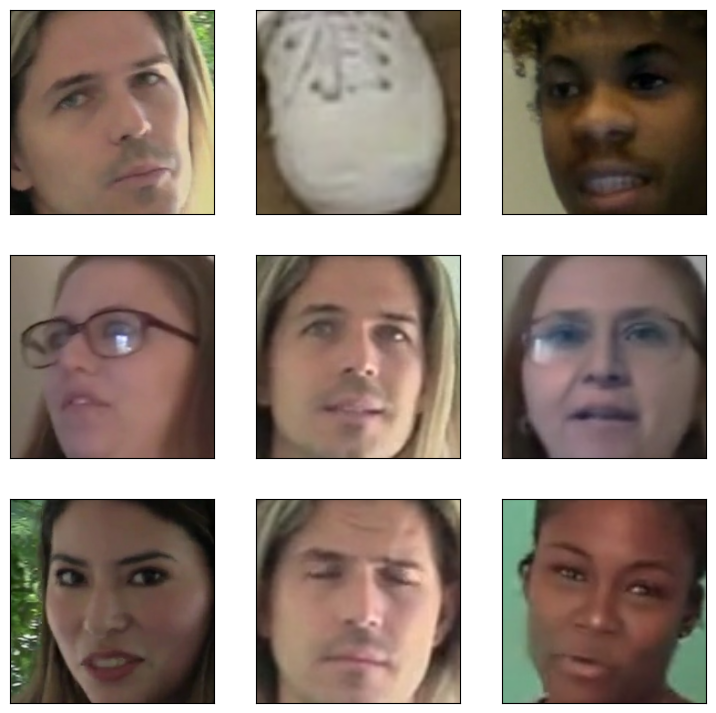

In [ ]:
sample = next(iter(train_dataset))
visualize(*sample)

anchor, positive, negative = sample
anchor_embedding, positive_embedding, negative_embedding = (
    embedding_model(vgg16.preprocess_input(anchor)),
    embedding_model(vgg16.preprocess_input(positive)),
    embedding_model(vgg16.preprocess_input(negative)),
)

positive_similarity = cosine_similarity(anchor_embedding, positive_embedding)
print("Positive similarity:", positive_similarity.numpy())

negative_similarity = cosine_similarity(anchor_embedding, negative_embedding)
print("Negative similarity", negative_similarity.numpy())


In [ ]:
cosine_similarity = metrics.CosineSimilarity()
positive_similarity = []
negative_similarity= []

train_dataset, val_dataset, test_dataset = preprocess_training_data()
test_dataset = test_dataset.batch(8, drop_remainder=False)
test_dataset = test_dataset.prefetch(8)


train_dataset = train_dataset.batch(8, drop_remainder=False)
train_dataset = train_dataset.prefetch(8)

for x,y,z in iter(train_dataset):
  anchor_embedding = embedding_model(vgg16.preprocess_input(x))
  positive_embedding = embedding_model(vgg16.preprocess_input(y))
  negative_embedding = embedding_model(vgg16.preprocess_input(z))

  positive_similarity.append(cosine_similarity(anchor_embedding, positive_embedding).numpy())
  negative_similarity.append(cosine_similarity(anchor_embedding, negative_embedding).numpy())


In [ ]:
falses = 0
for i in range(len(negative_similarity)):
  if negative_similarity[i] > positive_similarity[i]:
      falses+=1

In [ ]:
(len(negative_similarity)- falses)/len(negative_similarity)

0.8823529411764706

In [ ]:
cosine_similarity = metrics.CosineSimilarity()

positive_similarity = cosine_similarity(anchor_embedding, positive_embedding)
print("Positive similarity:", positive_similarity.numpy())

negative_similarity = cosine_similarity(anchor_embedding, negative_embedding)
print("Negative similarity", negative_similarity.numpy())

Positive similarity: 0.9999953
Negative similarity 0.99999225


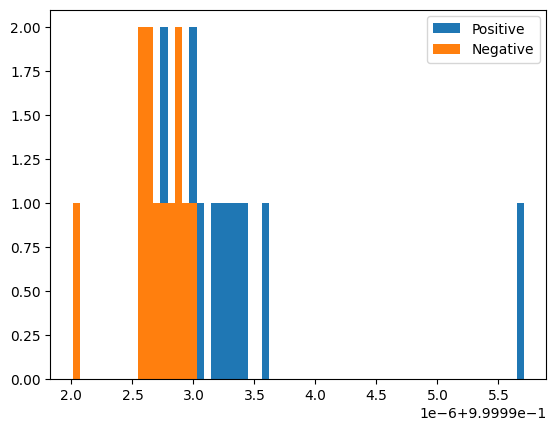

In [ ]:


plt.hist(positive_similarity, bins=50, label='Positive')
plt.hist(negative_similarity, bins=50, label='Negative')
plt.legend()
plt.show()

# Determine threshold based on cosine similarity distribution
threshold = np.mean(positive_similarity) - np.mean(negative_similarity)

In [ ]:
threshold

5.364418e-07

In [ ]:
sample = next(iter(train_dataset))
sample2 = next(iter(train_dataset))
sample3 = next(iter(train_dataset))

anchor, _, _ = sample
_, _, negative = sample2
unknown,_,_ = sample3



anchor_embedding, negative_embedding, unknown_image_embedding = (
  embedding_model(vgg16.preprocess_input(anchor)),
  embedding_model(vgg16.preprocess_input(negative)),
  embedding_model(vgg16.preprocess_input(unknown)),
)
positive_similarity = cosine_similarity(anchor_embedding, unknown_image_embedding).numpy()
negative_similarity = cosine_similarity(negative_embedding, unknown_image_embedding).numpy()

print(positive_similarity, negative_similarity)

0.9999918 0.99999124
